<a href="https://colab.research.google.com/github/eursamajor/Aksara/blob/main/Bali_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT DATA AND DATA AUGMENTATION

In [ ]:
import os
import shutil
import requests
import zipfile
from io import BytesIO
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, DenseNet201
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt

In [ ]:
dataset_dir = './drive/MyDrive/Aksara/Bali'

# new dir utk taroh 3 data
base_dir = './dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_name in os.listdir(dataset_dir):
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

# split data
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)

    train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

#augment
img_size = (224, 224)
batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=40,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest'
#                                    )
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 4179 images belonging to 28 classes.
Found 1396 images belonging to 28 classes.
Found 1406 images belonging to 28 classes.


### DEFINE MODEL

In [ ]:
def create_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = {
    'DenseNet169': DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224,3)),
    'DenseNet201': DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

results = {}

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### TRAIN AND EVALUATION

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model)
    history = model.fit(train_generator, validation_data=val_generator, epochs=30)

    test_loss, test_acc = model.evaluate(test_generator)
    results[model_name] = {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'test_accuracy': test_acc
    }

Training DenseNet169...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 470ms/step - accuracy: 0.3178 - loss: 16.1736 - val_accuracy: 0.8123 - val_loss: 0.6567
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.7892 - loss: 0.6543 - val_accuracy: 0.8632 - val_loss: 0.4463
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.8900 - loss: 0.3446 - val_accuracy: 0.9004 - val_loss: 0.3055
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.9342 - loss: 0.2174 - val_accuracy: 0.8926 - val_loss: 0.3498
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9561 - loss: 0.1385 - val_accuracy: 0.9083 - val_loss: 0.2972
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9457 - loss: 0.1684 - val_accuracy: 0.9148 - val_loss: 0.2940
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9515 - loss: 0.1532 - val_accuracy: 0.9169 - val_loss: 0.2698
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9615 - loss: 0.1116 - v

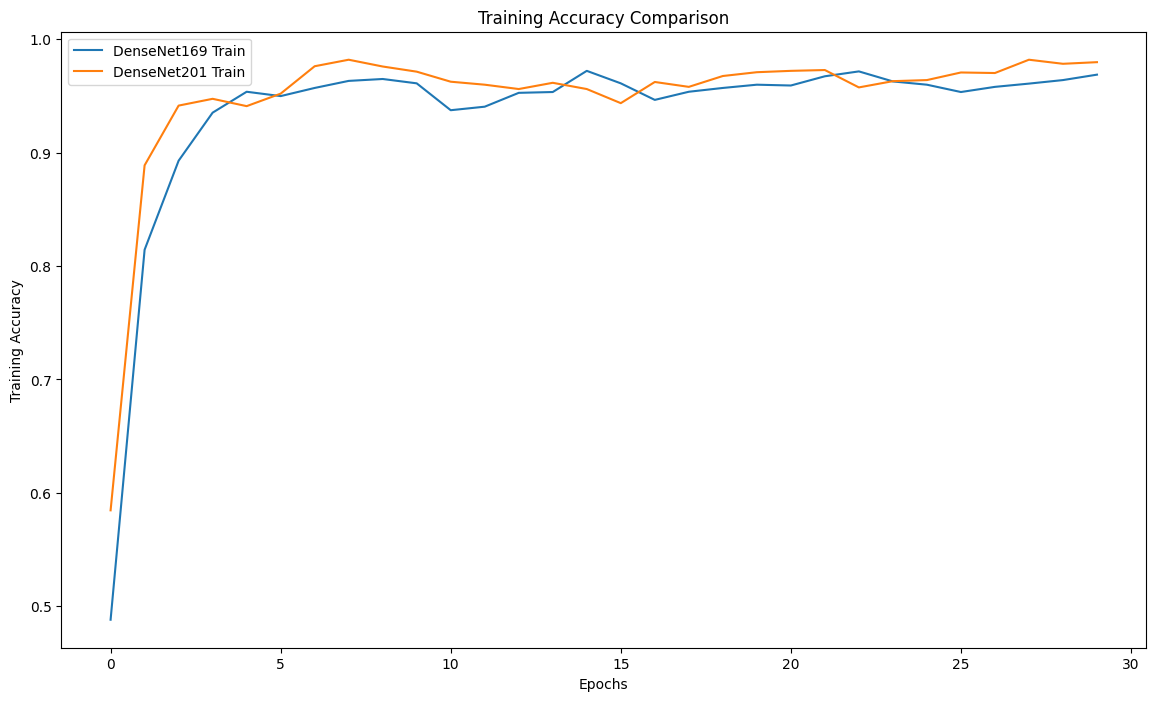

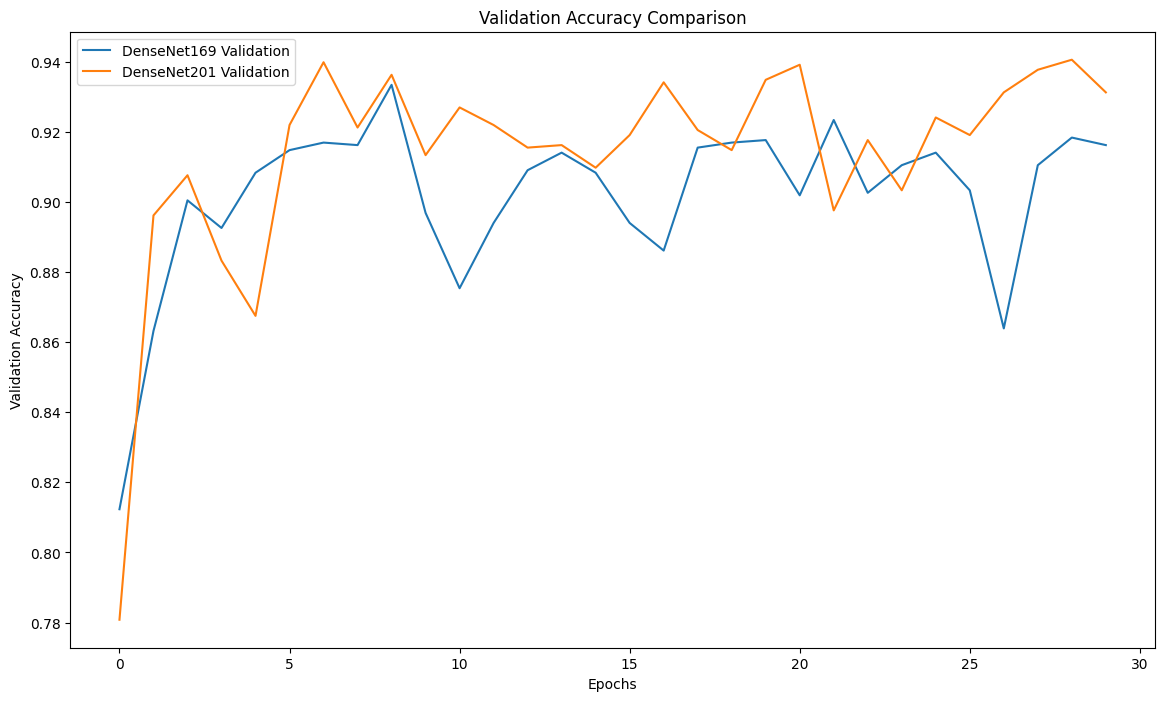

In [ ]:
# Plotting Training Accuracy
plt.figure(figsize=(14, 8))
for model_name, result in results.items():
    plt.plot(result['accuracy'], label=f"{model_name} Train")
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title('Training Accuracy Comparison')
plt.grid(False)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(14, 8))
for model_name, result in results.items():
    plt.plot(result['val_accuracy'], label=f"{model_name} Validation")
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.grid(False)
plt.show()